In [1]:
import numpy as np

import SimpleITK as sitk
from scipy.interpolate import RegularGridInterpolator

import matplotlib.pyplot as plt


In [33]:

def interp3(x,y,z,img_org, xr,yr,zr):
    """resampling"""
    
    xi,yi,zi = np.meshgrid(xr, yr, zr, indexing='ij')
    min_val = np.min(img_org)

    interp = RegularGridInterpolator((x,y,z),img_org,bounds_error=False,fill_value=min_val)
    img = interp( (xi,yi,zi)).astype(np.float32)
    
    return img


def centroid3(img):
    nx, ny, nz = img.shape
    # print(nx,ny,nz)
    imgx = np.sum(np.sum(img, axis=1), axis=1)
    imgy = np.sum(np.sum(img, axis=2), axis=0)
    imgz = np.sum(np.sum(img, axis=0), axis=0)
    denom = np.sum(np.sum(np.sum(img, axis=0), axis=0), axis=0)
    cx = np.sum(np.linspace(0, nx-1, nx)*imgx)/denom
    cy = np.sum(np.linspace(0, ny-1, ny)*imgy)/denom
    cz = np.sum(np.linspace(0, nz-1, nz)*imgz)/denom
    
    return cx, cy, cz
   
def plot_slice(ploting_ax, img,slice,axis):
    '''
        Plot img along a specific axis.
    '''

    if axis==0:
        ploting_ax.imshow(img[slice])
    elif axis==1:
        ploting_ax.imshow(img[:,slice,:])
    elif axis==2:
        ploting_ax.imshow(img[:,:,slice])
    return ploting_ax

def plot_img_at(img, coord):
    '''
        Plot the 3D slicing view of img at coord.
    '''

    l,p,s = coord
    
    axis_label ={"L":"L: left to right",
                 "P":"P: front to back",
                 "S":"S: feet to head"}

    ax = plt.subplot(1, 3, 1)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel(axis_label["P"])
    ax.set_ylabel(axis_label["S"])
    ax.invert_yaxis()

    ax.imshow(np.squeeze(img[l,:,:]).T)
    

    ax = plt.subplot(1, 3, 2)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel(axis_label["L"])
    ax.set_ylabel(axis_label["S"])
    ax.invert_yaxis()

    
    ax.imshow(np.squeeze(img[:,p,:]).T)
    

    ax = plt.subplot(1, 3, 3)
    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel(axis_label["L"])
    ax.set_ylabel(axis_label["P"])
    ax.invert_yaxis()


    ax.imshow(np.squeeze(img[:,:,s]).T)
    
    return ax
def sitk2numpy(sitk_img):
    '''
        Return a numpy array that has the same shape as the sitk image.
    '''
    out = (sitk.GetArrayFromImage(sitk_img)).astype(np.float32)
    return out


In [13]:
vessel_us = sitk.ReadImage('vess_us.nii.gz')

vessel_ct = sitk.ReadImage('vessel_ct.nii.gz')
o = [True,False,False] # The left-right order is different between the US image and CT image. We flip vessel_ct to make them consistent.
vessel_ct = sitk.Flip(vessel_ct,o)


# 3D Registration

In [14]:
## resampling reference size and resolution

ref_dx, ref_dy, ref_dz = 1.0, 1.0, 1.0
# ref_nx, ref_ny, ref_nz = 384, 384, 384
ref_nx, ref_ny, ref_nz = 250, 250, 300

xr = (np.linspace(0, ref_nx-1, ref_nx) - (ref_nx-1)/2.0)*ref_dx
yr = (np.linspace(0, ref_ny-1, ref_ny) - (ref_ny-1)/2.0)*ref_dy
zr = (np.linspace(0, ref_nz-1, ref_nz) - (ref_nz-1)/2.0)*ref_dz

In [15]:
ct_shape = vessel_ct.GetSize()
ct_res = vessel_ct.GetSpacing()

In [16]:
print(ct_shape)
print(ct_res)

(512, 512, 256)
(0.699999988079071, 0.699999988079071, 0.699999988079071)


(500, 1080, 69) (0.18007202446460724, 0.18007202446460724, 0.7231450080871582)


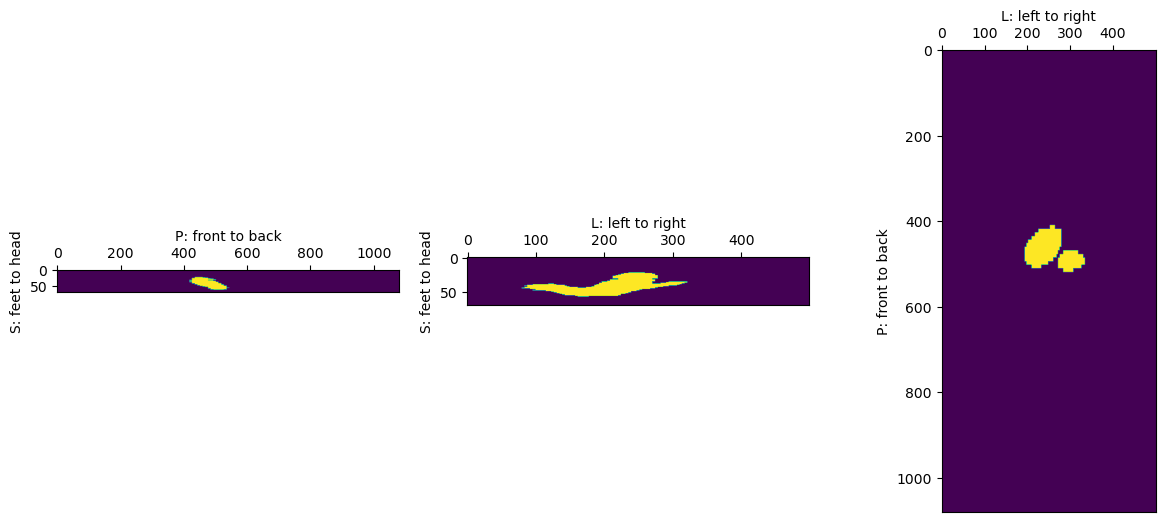

In [34]:
us_shape = vessel_us.GetSize()
us_res = vessel_us.GetSpacing()
print(us_shape,us_res)


us_img_0 = (sitk.GetArrayFromImage(vessel_us)).astype(np.float32)
# z,y,x->x,y,z
us_img_0 = np.swapaxes(us_img_0,0,2)


plt.figure(figsize=(15,6))

plot_img_at(us_img_0,np.array(centroid3(us_img_0)).astype(int))
plt.show()

In [30]:
tmp_ct_img = (sitk.GetArrayFromImage(vessel_ct)).astype(np.float32)
# z,y,x->x,y,z
tmp_ct_img = np.swapaxes(tmp_ct_img,0,2)

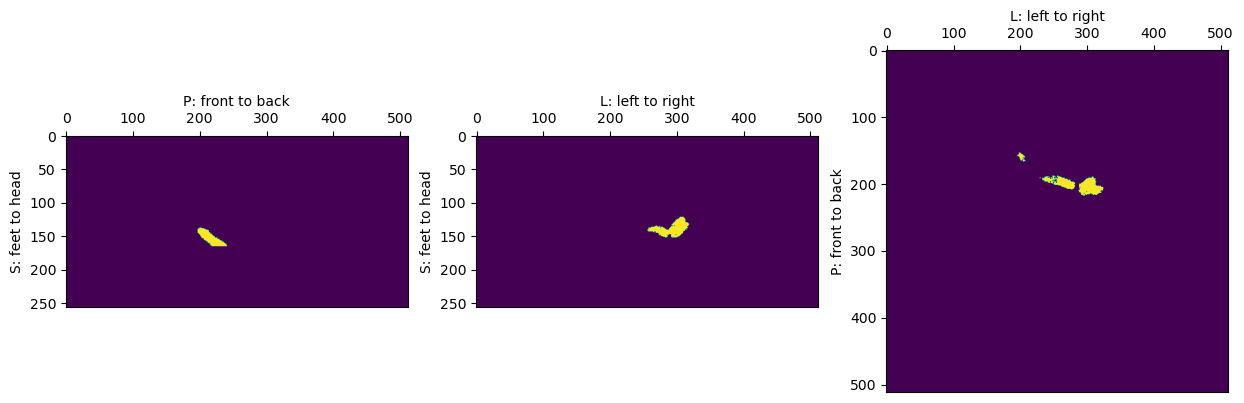

In [35]:
plt.figure(figsize=(15,6))


plot_img_at(tmp_ct_img,np.array(centroid3(tmp_ct_img)).astype(int))
plt.show()

In [36]:
## resampling ct and ultrasound images
x = (np.linspace(0, ct_shape[0]-1, ct_shape[0]) - (ct_shape[0]-1)/2.0)*ct_res[0]
y = (np.linspace(0, ct_shape[1]-1, ct_shape[1]) - (ct_shape[1]-1)/2.0)*ct_res[1]
z = (np.linspace(0, ct_shape[2]-1, ct_shape[2]) - (ct_shape[2]-1)/2.0)*ct_res[2]
img_ct = interp3(x, y, z, tmp_ct_img, xr, yr, zr)

###### The center pixel of us_img_0 is defined as the origin of the cartesian continuous coordinate frame ######
x = (np.linspace(0, us_shape[0]-1, us_shape[0]) - (us_shape[0]-1)/2.0)*us_res[0] 
y = (np.linspace(0, us_shape[1]-1, us_shape[1]) - (us_shape[1]-1)/2.0)*us_res[1]
z = (np.linspace(0, us_shape[2]-1, us_shape[2]) - (us_shape[2]-1)/2.0)*us_res[2]
us_img_1 = interp3(x, y, z, us_img_0, xr, yr, zr)
###### The center pixel of us_img_1 and has the same continuous coordinate as the center pixel of us_img_0. ######

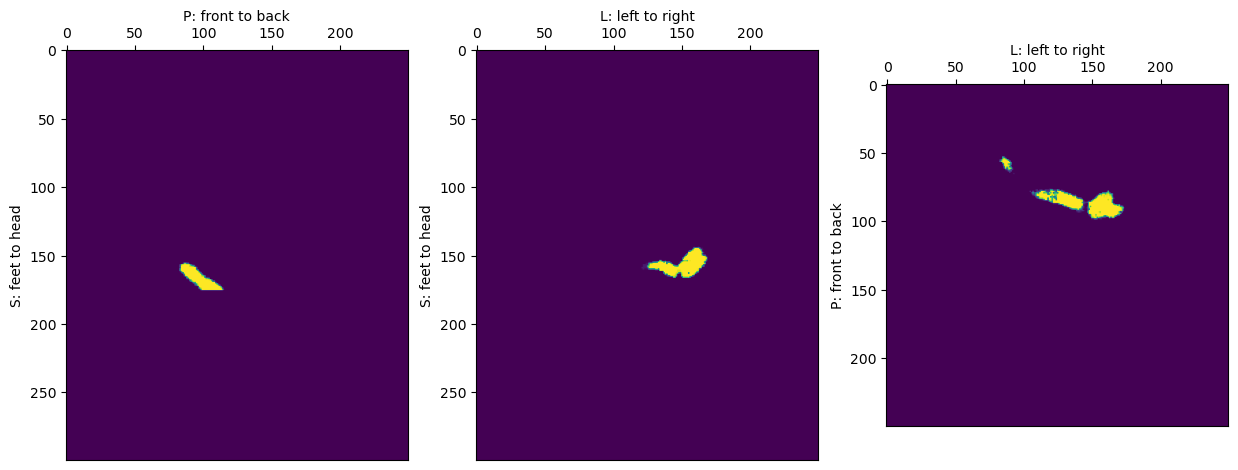

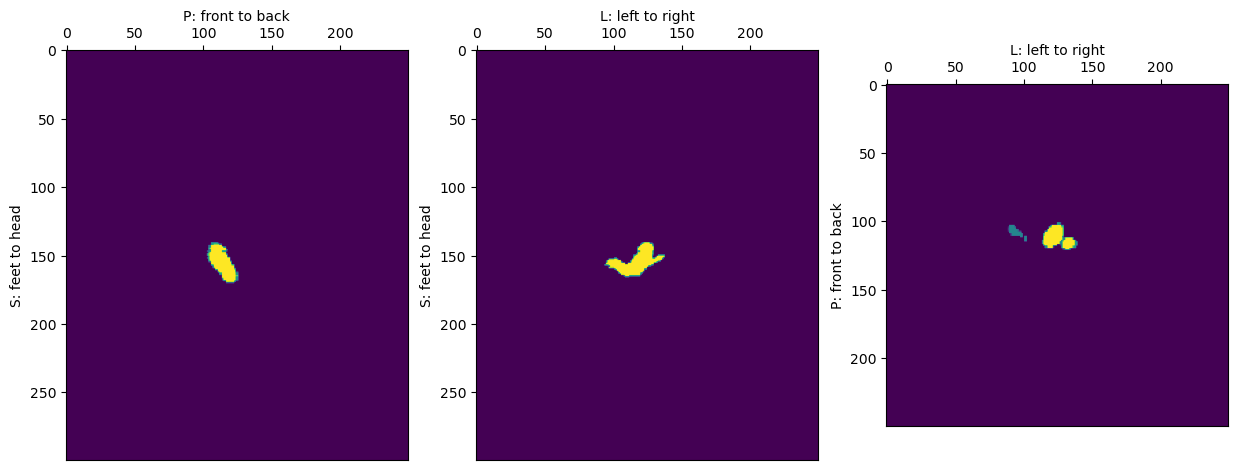

In [37]:
plt.figure(figsize=(15,6))
tmp = img_ct
plot_img_at(tmp,np.array(centroid3(tmp)).astype(int))
plt.show()

# adjust to the same image shape and direction >> depending on the probe position: need to be fixed.
plt.figure(figsize=(15,6))
tmp = us_img_1
plot_img_at(tmp,np.array(centroid3(tmp)).astype(int))
plt.show()